<a href="https://colab.research.google.com/github/zia207/r-colab/blob/main/NoteBook/Advance_Regression/02-01-03-glm-probit-r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1IFEWet-Aw4DhkkVe1xv_2YYqlvRe9m5_)

# 3. Probit Regression

Probit regression model is a statistical technique used to model binary response variables. It estimates the probability of an event occurring based on various predictor variables. This probability is represented using the cumulative distribution function (CDF) of a normal distribution, making probit regression a solid alternative to logistic regression when the normality assumptions are met. In this tutorial, we will provide an overview of the Probit Model. We will walk through a manual fitting process using maximum likelihood estimation (MLE) to understand the mechanics behind the model. Then, we will demonstrate how to fit a probit model in R using the `glm()` function. We'll also cover how to interpret the model outputs, evaluate model performance, and visualize the results using different R packages. By the end of this tutorial, you will have a solid understanding of the probit model and how to apply it in R for your research or projects. Let’s get started!


## Overview

The **Probit Model** estimates the probability that an outcome $ Y = 1 $ given a set of independent variables $ X $. It does so by assuming that the **latent (unobserved) variable** follows a **normal distribution**.

Instead of directly modeling the probability, the Probit model uses the **cumulative distribution function (CDF)** of the **standard normal distribution** to link the linear combination of predictors to the probability of the outcome.


### How the Probit Model Works

Let’s suppose we have a binary outcome variable:

- $ Y_i = 1 $: success/event occurs
- $ Y_i = 0 $: failure/event does not occur

We model the **probability** that $ Y_i = 1 $ given predictors $ X_i $ as:

$$
P(Y_i = 1 \mid X_i) = \Phi(X_i\beta)
$$

Where:
- $ X_i $ is a vector of explanatory variables (e.g., age, income, etc.)
- $ \beta $ is a vector of coefficients to be estimated
- $ \Phi(\cdot) $ is the **cumulative distribution function (CDF)** of the **standard normal distribution**
- $ X_i\beta $ is the linear predictor (like in linear regression)

#### Latent Variable Interpretation

The Probit model can be understood using a **latent variable** $ Y_i^* $:

$$
Y_i^* = X_i\beta + \varepsilon_i, \quad \varepsilon_i \sim N(0, 1)
$$

Then the observed outcome is:

$$
Y_i = 
\begin{cases}
1 & \text{if } Y_i^* > 0 \\
0 & \text{if } Y_i^* \leq 0
\end{cases}
$$

So:
$$
P(Y_i = 1 \mid X_i) = P(Y_i^* > 0) = P(\varepsilon_i > -X_i\beta) = P(\varepsilon_i \leq X_i\beta) = \Phi(X_i\beta)
$$

This shows how the normality assumption leads to the use of $ \Phi $.



#### Estimation

The parameters $ \beta $ are estimated using **Maximum Likelihood Estimation (MLE)**. The likelihood function is built from the probabilities:

$$
L(\beta) = \prod_{i=1}^{n} \left[\Phi(X_i\beta)\right]^{Y_i} \left[1 - \Phi(X_i\beta)\right]^{1 - Y_i}
$$

We maximize this likelihood (or the log-likelihood) numerically to obtain $ \hat{\beta} $.



#### Interpretation of Coefficients

The coefficients $ \beta $ in a Probit model are **not directly interpretable** as changes in probability. Instead:
- A positive $ \beta_j $ means that an increase in $ X_j $ increases the **z-score** (probit index), thus increasing the probability that $ Y = 1 $
- To interpret the effect on probability, we compute **marginal effects**:
  $$
  \frac{\partial P(Y=1 \mid X)}{\partial X_j} = \phi(X\beta) \cdot \beta_j
  $$
  where $ \phi(\cdot) $ is the **standard normal PDF**.




### Applications of the Probit Model

Probit models are widely used in:
- **Economics**: modeling labor force participation (work vs. not work)
- **Medicine**: probability of disease given risk factors
- **Political science**: voting behavior (vote vs. not vote)
- **Finance**: default prediction (default vs. no default)

###  Probit vs Logistic Regression: Key Differences

| Feature | **Probit Model** | **Logistic Regression (Logit)** |
|--------|------------------|-------------------------------|
| **Link Function** | Uses **CDF of standard normal** $ \Phi(\cdot) $ | Uses **logistic CDF** $ \frac{1}{1 + e^{-z}} $ |
| **Distribution Assumption** | Error term $ \varepsilon_i \sim N(0,1) $ | Implicitly assumes logistic-distributed errors |
| **Shape of CDF** | Slightly steeper in the middle, lighter tails | Slightly flatter in middle, heavier tails |
| **Interpretability** | Coefficients less intuitive; marginal effects needed | Coefficients can be interpreted via **odds ratios** |
| **Computation** | Requires numerical integration (slightly more complex) | Simpler computation; log-likelihood easier to optimize |
| **Tail Behavior** | Assigns lower probability to extreme outcomes | More robust to outliers due to heavier tails |
| **Common Usage** | Popular in econometrics | More common in biostatistics, machine learning |




### When to Use Probit vs Logit?

- **Probit** is preferred when:

  - The underlying latent variable is assumed to be normally distributed.
  - You're in an econometric context and want to use models like **bivariate probit** or **multinomial probit**.
  - You want slightly more efficient estimates under normality (in theory).

- **Logit** is preferred when:

  - Interpretability via **odds ratios** is important.
  - You're dealing with case-control studies or medical research.
  - You want simpler interpretation and computation.
  - Outliers are a concern (due to heavier tails).

**In practice**, both models often yield **very similar results**. The choice between them is usually based on **convention in the field** or **specific model extensions** (e.g., multinomial models, panel data).

## Probit Model  from Scratch

Building a Probit model from scratch in Python involves generating synthetic data, implementing the model fitting process, creating a summary table for model parameters, performing cross-validation, and evaluating model performance. Here’s a step-by-step guide on how to accomplish this in R without using any external packages.

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import norm
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings("ignore")

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Data Generation

Let's start by generating synthetic data with four covariates and a binary outcome.

In [2]:
# Set random seed for reproducibility
np.random.seed(123)

# Number of observations
n = 1000

# Generate four covariates
X1 = np.random.randn(n)
X2 = np.random.randn(n)
X3 = np.random.randn(n)
X4 = np.random.randn(n)

# True coefficients (intercept + 4 predictors)
beta_true = np.array([0.5, -1.0, 0.8, -0.6, 1.2])

# Linear predictor (latent variable)
latent_variable = (beta_true[0] + beta_true[1]*X1 + beta_true[2]*X2 +
                   beta_true[3]*X3 + beta_true[4]*X4)

# Generate binary outcome: Y = 1 if latent + noise > 0
Y = (latent_variable + np.random.randn(n) > 0).astype(int)

# Combine into a DataFrame
data = pd.DataFrame({'Y': Y, 'X1': X1, 'X2': X2, 'X3': X3, 'X4': X4})

### Model Fitting

Now, we define a function to fit the Probit model using maximum likelihood estimation. We use the cumulative distribution function (CDF) of the normal distribution to transform the linear predictor into probabilities, then maximize the log-likelihood function.

In [3]:
# Log-likelihood function for Probit
def log_likelihood(beta, Y, X):
    linear_pred = X @ beta
    p = norm.cdf(linear_pred)
    # Avoid log(0) by clipping probabilities
    p = np.clip(p, 1e-10, 1 - 1e-10)
    ll = np.sum(Y * np.log(p) + (1 - Y) * np.log(1 - p))
    return -ll  # Return negative for minimization

# Function to fit Probit model
def fit_probit(Y, X):
    # Add intercept
    X = np.column_stack([np.ones(X.shape[0]), X])
    initial_beta = np.zeros(X.shape[1])
    
    # Optimize using BFGS
    result = minimize(log_likelihood, initial_beta, args=(Y, X), method='BFGS', hess=None)
    
    if not result.success:
        raise RuntimeError("Optimization failed: " + result.message)
    
    return {
        'coefficients': result.x,
        'hessian': result.hess_inv,  # Approximate inverse Hessian
        'convergence': result.success
    }

# Fit the model
X_pred = data[['X1', 'X2', 'X3', 'X4']].values
Y_out = data['Y'].values
fit = fit_probit(Y_out, X_pred)

### Summary Statistic Table

We use the fitted model to calculate standard errors, z-values, and p-values for each coefficient.

In [4]:
def create_summary_table(fit):
    beta_hat = fit['coefficients']
    hessian_inv = fit['hessian']  # This is the inverse Hessian (approx. covariance)
    
    # Extract covariance matrix (from inverse Hessian)
    cov_matrix = hessian_inv  # scipy.optimize returns inverse Hessian in BFGS
    standard_errors = np.sqrt(np.diag(cov_matrix))
    
    # Calculate z-values and p-values
    z_values = beta_hat / standard_errors
    p_values = 2 * (1 - norm.cdf(np.abs(z_values)))
    
    # Create summary table
    summary_table = pd.DataFrame({
        'Coefficient': beta_hat,
        'Std.Error': standard_errors,
        'z.value': z_values,
        'p.value': p_values
    }, index=['Intercept', 'X1', 'X2', 'X3', 'X4'])
    
    return summary_table

# Generate and print summary
summary_table = create_summary_table(fit)
print(summary_table)

           Coefficient  Std.Error    z.value  p.value
Intercept     0.565189   0.056602   9.985365      0.0
X1           -1.046996   0.073502 -14.244545      0.0
X2            0.818615   0.067814  12.071451      0.0
X3           -0.596935   0.059261 -10.073068      0.0
X4            1.212010   0.077470  15.644893      0.0


### Risk Ratios

In a probit model, the **risk ratio** isn’t calculated directly in the same way as it would be for a linear model or a log-binomial model. This is because the probit model uses the cumulative distribution function of a standard normal distribution (Φ) to estimate the probability of an outcome, based on the relationship:

$$ P(Y=1∣X)=Φ(Xβ)$$

-   where $X$ is your predictor, then calculate:

    $$ P(Y=1∣X=1)=Φ(β0+β1)$$

    and

    $$ P(Y=1∣X=0)=Φ(β0) $$

-   **Approximate the Risk Ratio**: Compute the ratio of these two predicted probabilities:

    $$ text{Approximate Risk Ratio} = \frac{P(Y = 1 | X = 1)}{P(Y = 1 | X = 0)} $$

where $\Phi$ is the cumulative distribution function of the standard normal distribution, $X$ represents the predictors, and $\beta$ represents the coefficients


In [5]:
# Extract coefficients
beta_0 = summary_table.loc['Intercept', 'Coefficient']  # Intercept
beta_1 = summary_table.loc['X1', 'Coefficient']         # Coefficient for X1

# Predicted probabilities at X1 = 1 and X1 = 0 (others at mean 0 assumed)
p_X1 = norm.cdf(beta_0 + beta_1)  # P(Y=1 | X1=1, others=0)
p_X0 = norm.cdf(beta_0)           # P(Y=1 | X1=0, others=0)

# Approximate Risk Ratio
approx_risk_ratio = p_X1 / p_X0
print(f"Approximate Risk Ratio: {approx_risk_ratio:.4f}")

Approximate Risk Ratio: 0.4411


### Cross-Validation

We implement k-fold cross-validation (using `k=5` as an example) to evaluate the model’s performance.

In [6]:
def cross_validation_probit(data, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=456)
    accuracies = []
    
    X_full = data[['X1', 'X2', 'X3', 'X4']].values
    Y_full = data['Y'].values
    
    for train_index, test_index in kf.split(X_full):
        X_train, X_test = X_full[train_index], X_full[test_index]
        Y_train, Y_test = Y_full[train_index], Y_full[test_index]
        
        # Fit model on training data
        fit_cv = fit_probit(Y_train, X_train)
        beta_hat = fit_cv['coefficients']
        
        # Predict on test data
        X_test_int = np.column_stack([np.ones(X_test.shape[0]), X_test])
        linear_pred = X_test_int @ beta_hat
        probabilities = norm.cdf(linear_pred)
        predictions = (probabilities > 0.5).astype(int)
        
        # Accuracy
        accuracy = np.mean(predictions == Y_test)
        accuracies.append(accuracy)
    
    return np.mean(accuracies)

# Perform 5-fold CV
cv_accuracy = cross_validation_probit(data, k=5)
print(f"Average Accuracy from 5-Fold Cross-Validation: {cv_accuracy:.4f}")

Average Accuracy from 5-Fold Cross-Validation: 0.8410


### Model Evaluation

Finally, we evaluate the fitted model on the entire dataset, calculating the accuracy, sensitivity, and specificity.

In [7]:

def evaluate_probit_model(Y, X, beta_hat):
    # Add intercept
    X = np.column_stack([np.ones(X.shape[0]), X])
    linear_pred = X @ beta_hat
    probabilities = norm.cdf(linear_pred)
    predictions = (probabilities > 0.5).astype(int)
    
    # Accuracy
    accuracy = np.mean(predictions == Y)
    
    # Confusion matrix components
    tp = np.sum((predictions == 1) & (Y == 1))
    tn = np.sum((predictions == 0) & (Y == 0))
    fp = np.sum((predictions == 1) & (Y == 0))
    fn = np.sum((predictions == 0) & (Y == 1))
    
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    evaluation = pd.DataFrame({
        'Metric': ['Accuracy', 'Sensitivity', 'Specificity'],
        'Value': [accuracy, sensitivity, specificity]
    })
    
    return evaluation

# Evaluate on full dataset
evaluation_results = evaluate_probit_model(Y_out, X_pred, fit['coefficients'])
print(evaluation_results)

        Metric     Value
0     Accuracy  0.845000
1  Sensitivity  0.880952
2  Specificity  0.783784


##  Probit Model with Python



In [57]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm
from scipy.stats import f_oneway
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.formula.api import glm
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import probit
import warnings
warnings.filterwarnings("ignore")

# Set style
plt.style.use('default')
sns.set_palette("Set2")
np.random.seed(123)

### Data

In this exercise we will use [Pima Indians Diabetes Database](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database). This dataset was obtained from the National Institute of Diabetes and Digestive and Kidney Diseases. The goal of this dataset is to predict whether or not a patient has diabetes, using specific diagnostic measurements included in the data. Some limitations were put in place while selecting instances from a larger database. Specifically, all the patients in this dataset are female, at least 21 years old, and of Pima Indian ancestry.

In [ ]:
# Load data

url = "https://github.com/zia207/r-colab/raw/main/Data/Regression_analysis/puma_diabetes.csv"
df_raw = pd.read_csv(url)

# Rename columns
df_raw.columns = ['Preg', 'Gluc', 'BP', 'Skin', 'Insulin', 'BMI', 'DPF', 'Age', 'Outcome']

print("Dataset Shape:", df_raw.shape)
print("\nFirst 5 Rows:")
print(df_raw.head())

print("\nData Info:")
print(df_raw.info())

Dataset Shape: (768, 9)

First 5 Rows:
   Preg  Gluc  BP  Skin  Insulin   BMI    DPF  Age  Outcome
0     6   148  72    35        0  33.6  0.627   50        1
1     1    85  66    29        0  26.6  0.351   31        0
2     8   183  64     0        0  23.3  0.672   32        1
3     1    89  66    23       94  28.1  0.167   21        0
4     0   137  40    35      168  43.1  2.288   33        1

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Preg     768 non-null    int64  
 1   Gluc     768 non-null    int64  
 2   BP       768 non-null    int64  
 3   Skin     768 non-null    int64  
 4   Insulin  768 non-null    int64  
 5   BMI      768 non-null    float64
 6   DPF      768 non-null    float64
 7   Age      768 non-null    int64  
 8   Outcome  768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None



* Preg - Number of times pregnant	Numeric	[0, 17]

* Gluc - 	Plasma glucose concentration at 2 Hours in an oral glucose tolerance test (GTIT)	Numeric	[0, 199]

* BP - 	Diastolic Blood Pressure (mm Hg)	Numeric	[0, 122]

* Skin - Triceps skin fold thickness (mm)	Numeric	[0, 99]

* Insulin - 	2-Hour Serum insulin (µh/ml)	Numeric	[0, 846]

* BMI	- Body mass index [weight in kg/(Height in m)]	Numeric	[0, 67.1]

* DPF - 	Diabetes pedigree function	Numeric	[0.078, 2.42]

* Age - 	Age (years)	Numeric	[21, 81].

* Outcome - Binary value indicating non-diabetic /diabetic	Factor	[0,1]

Source:Chang V, Bailey J, Xu QA, Sun Z. [Pima Indians diabetes mellitus classification based on machine learning (ML) algorithms](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8943493/). Neural Comput Appl. 2022 Mar 24:1-17. doi: 10.1007/s00521-022-07049-z. Epub ahead of print. PMID: 35345556; PMCID: PMC8943493.



#### Plot basic data information



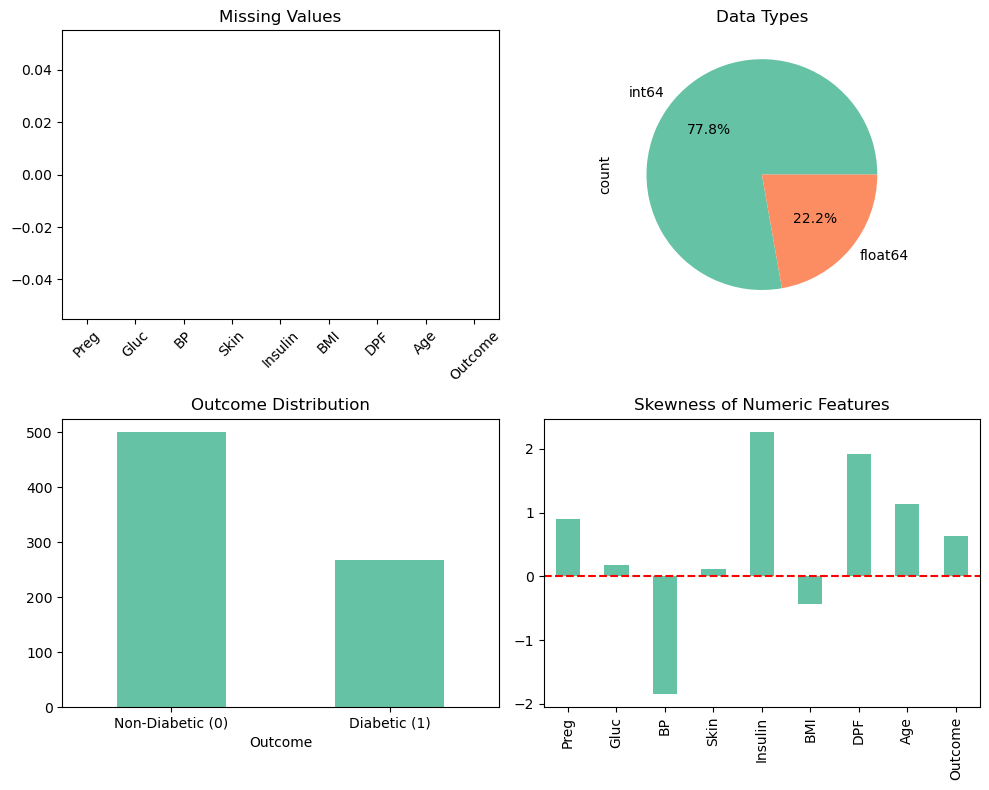

In [59]:
def plot_intro(df):
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    
    # Missing values
    df.isnull().sum().plot(kind='bar', ax=axes[0,0], title='Missing Values')
    axes[0,0].tick_params(axis='x', rotation=45)

    # Data types
    df.dtypes.value_counts().plot(kind='pie', ax=axes[0,1], title='Data Types', autopct='%1.1f%%')

    # Outcome distribution
    df['Outcome'].value_counts().plot(kind='bar', ax=axes[1,0], title='Outcome Distribution')
    axes[1,0].set_xticklabels(['Non-Diabetic (0)', 'Diabetic (1)'], rotation=0)

    # Skewness
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    skewness = df[numeric_cols].skew()
    skewness.plot(kind='bar', ax=axes[1,1], title='Skewness of Numeric Features')
    axes[1,1].axhline(0, color='red', linestyle='--')

    plt.tight_layout()
    plt.show()

plot_intro(df_raw)

#### Summary Statistics

In [18]:
numeric_cols = ['Preg', 'Gluc', 'BP', 'Skin', 'Insulin', 'BMI', 'Age']
summary = df_raw[numeric_cols].describe().T
summary['skew'] = df_raw[numeric_cols].skew()
print(summary.round(3))

         count     mean      std   min   25%    50%     75%    max   skew
Preg     768.0    3.845    3.370   0.0   1.0    3.0    6.00   17.0  0.902
Gluc     768.0  120.895   31.973   0.0  99.0  117.0  140.25  199.0  0.174
BP       768.0   69.105   19.356   0.0  62.0   72.0   80.00  122.0 -1.844
Skin     768.0   20.536   15.952   0.0   0.0   23.0   32.00   99.0  0.109
Insulin  768.0   79.799  115.244   0.0   0.0   30.5  127.25  846.0  2.272
BMI      768.0   31.993    7.884   0.0  27.3   32.0   36.60   67.1 -0.429
Age      768.0   33.241   11.760  21.0  24.0   29.0   41.00   81.0  1.130


#### Correlation

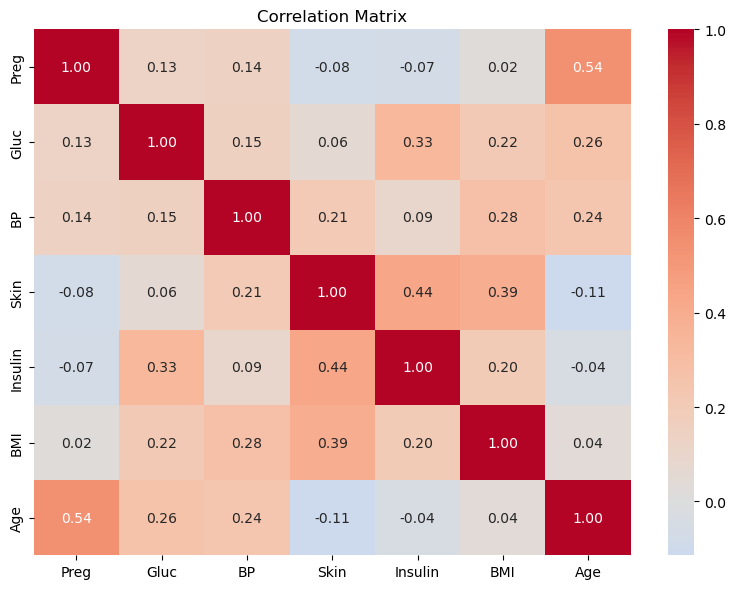

In [19]:
cor_data = df_raw[numeric_cols].corr()

# Plot correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cor_data, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

#### Boxplots with Statistical Tests (ANOVA)

We can create a nice looking plots with results of ANOVA and post-hoc tests on the same plot (directly on the boxplots). 

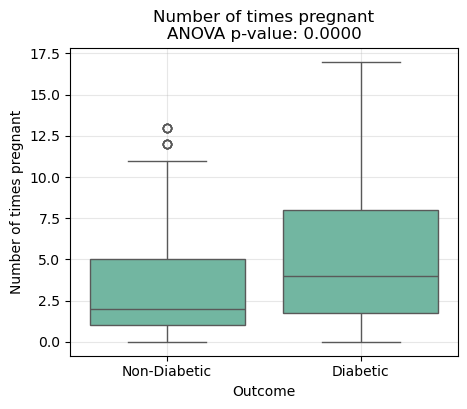

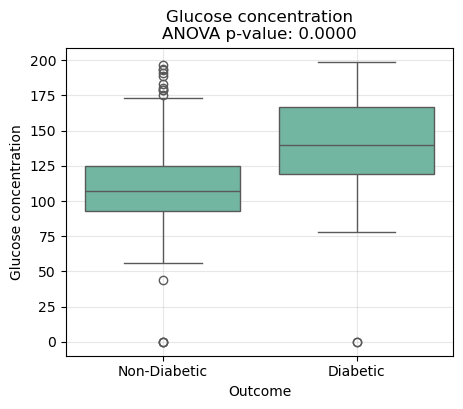

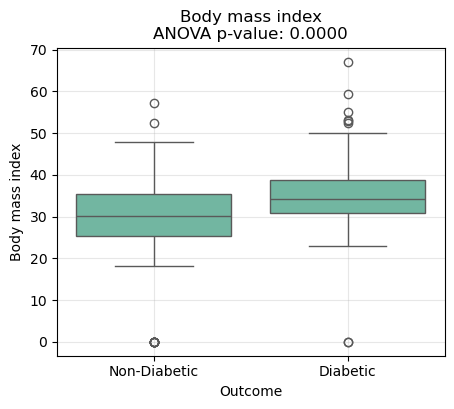

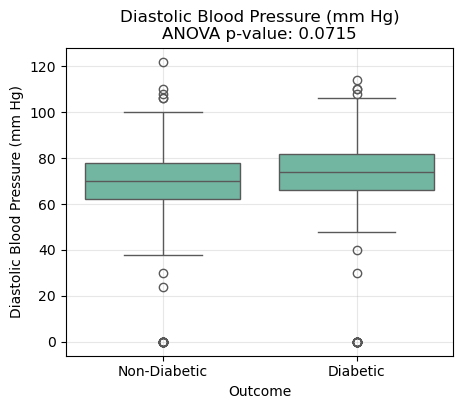

In [60]:
from scipy.stats import f_oneway

def plot_box_with_stats(data, x_col, y_col, y_label, title):
    # Drop NaN
    sub_data = data[[x_col, y_col]].dropna()
    
    # ANOVA
    group_0 = sub_data[sub_data[x_col] == 0][y_col]
    group_1 = sub_data[sub_data[x_col] == 1][y_col]
    f_stat, p_val = f_oneway(group_0, group_1)
    
    # Plot
    plt.figure(figsize=(5, 4))
    sns.boxplot(data=sub_data, x=x_col, y=y_col)
    plt.title(f"{title}\nANOVA p-value: {p_val:.4f}")
    plt.xlabel("Outcome")
    plt.ylabel(y_label)
    plt.xticks([0,1], ['Non-Diabetic', 'Diabetic'])
    plt.grid(True, alpha=0.3)
    plt.show()

for col, label in zip(['Preg', 'Gluc', 'BMI', 'BP'],
                      ['Number of times pregnant', 'Glucose concentration',
                       'Body mass index', 'Diastolic Blood Pressure (mm Hg)']):
    plot_box_with_stats(df_raw, 'Outcome', col, label, label)

#### Data Processing

In [61]:
# Handle zero-values (non-physiological) for key features
zero_columns = ['Gluc', 'BP', 'Skin', 'Insulin', 'BMI']
for col in zero_columns:
    df_raw[col] = df_raw[col].replace(0, np.nan)

# Impute missing values with median
df_clean = df_raw.copy()
for col in zero_columns:
    df_clean[col] = df_clean[col].fillna(df_clean[col].median())

# Normalize numerical features (min-max)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_scaled = df_clean.copy()
df_scaled[numeric_cols] = scaler.fit_transform(df_scaled[numeric_cols])

# Convert Outcome to categorical
df_scaled['Outcome'] = df_scaled['Outcome'].astype('category')

print("Preprocessed data (first 5 rows):")
print(df_scaled.head())

Preprocessed data (first 5 rows):
       Preg      Gluc        BP      Skin   Insulin       BMI    DPF  \
0  0.352941  0.670968  0.489796  0.304348  0.133413  0.314928  0.627   
1  0.058824  0.264516  0.428571  0.239130  0.133413  0.171779  0.351   
2  0.470588  0.896774  0.408163  0.239130  0.133413  0.104294  0.672   
3  0.058824  0.290323  0.428571  0.173913  0.096154  0.202454  0.167   
4  0.000000  0.600000  0.163265  0.304348  0.185096  0.509202  2.288   

        Age Outcome  
0  0.483333       1  
1  0.166667       0  
2  0.183333       1  
3  0.000000       0  
4  0.200000       1  


#### Split Data

In [22]:
# Stratified split to preserve Outcome distribution
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=101)
train_idx, test_idx = next(splitter.split(df_scaled, df_scaled['Outcome']))

train = df_scaled.iloc[train_idx].copy()
test = df_scaled.iloc[test_idx].copy()

# Check proportions
print("Training set Outcome proportions:")
print(train['Outcome'].value_counts(normalize=True))

print("\nTest set Outcome proportions:")
print(test['Outcome'].value_counts(normalize=True))

Training set Outcome proportions:
Outcome
0    0.651769
1    0.348231
Name: proportion, dtype: float64

Test set Outcome proportions:
Outcome
0    0.649351
1    0.350649
Name: proportion, dtype: float64


### Fit a Probit Model

We will use **Probit regression** to predict customer feed back based on various attributes related to occupation, family Size, location etc. We will use `glm()` function with `family = binomial(link = "probit"))` for probit regression.

In [62]:
# Define formula
formula = "Outcome ~ Preg + Gluc + BP + Skin + Insulin + BMI + DPF + Age"

# Fit Probit model
model_probit = glm(formula, data=train, family=Binomial(link=probit())).fit()

print(model_probit.summary())

                      Generalized Linear Model Regression Results                       
Dep. Variable:     ['Outcome[0]', 'Outcome[1]']   No. Observations:                  537
Model:                                      GLM   Df Residuals:                      528
Model Family:                          Binomial   Df Model:                            8
Link Function:                           probit   Scale:                          1.0000
Method:                                    IRLS   Log-Likelihood:                -242.74
Date:                          Mon, 11 Aug 2025   Deviance:                       485.49
Time:                                  15:32:18   Pearson chi2:                     522.
No. Iterations:                               7   Pseudo R-squ. (CS):             0.3220
Covariance Type:                      nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------

In [63]:
# Coefficients and confidence intervals
summary_df = pd.DataFrame({
    'Coefficient': model_probit.params,
    'Std. Error': model_probit.bse,
    'z-value': model_probit.tvalues,
    'p-value': model_probit.pvalues,
    'OR (exp(coef))': np.exp(model_probit.params),
    '2.5%': model_probit.conf_int()[0],
    '97.5%': model_probit.conf_int()[1]
})
print(summary_df.round(4))

           Coefficient  Std. Error  z-value  p-value  OR (exp(coef))    2.5%  \
Intercept       3.5307      0.3630   9.7252   0.0000         34.1466  2.8191   
Preg           -1.1724      0.3780  -3.1013   0.0019          0.3096 -1.9133   
Gluc           -3.5295      0.3994  -8.8362   0.0000          0.0293 -4.3124   
BP              0.3507      0.5974   0.5870   0.5572          1.4201 -0.8202   
Skin           -0.7509      0.8504  -0.8830   0.3772          0.4720 -2.4175   
Insulin         0.2921      0.6624   0.4410   0.6592          1.3392 -1.0061   
BMI            -2.2534      0.5956  -3.7832   0.0002          0.1050 -3.4209   
DPF            -0.4246      0.2037  -2.0846   0.0371          0.6540 -0.8238   
Age            -0.6335      0.4097  -1.5462   0.1221          0.5307 -1.4365   

            97.5%  
Intercept  4.2422  
Preg      -0.4315  
Gluc      -2.7467  
BP         1.5216  
Skin       0.9158  
Insulin    1.5903  
BMI       -1.0860  
DPF       -0.0254  
Age        0.1695  

### Visualization of Coefficients

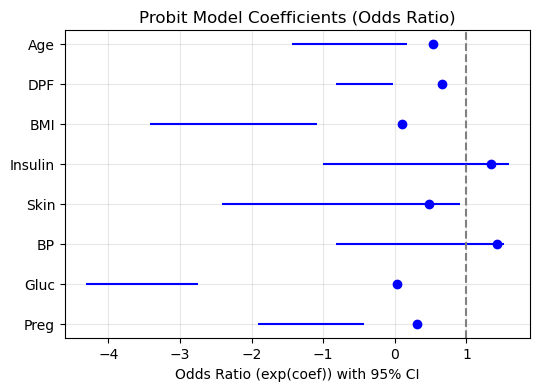

In [28]:
''
# Plot odds ratios
coef_data = summary_df.copy()
coef_data.index = coef_data.index.str.replace('Outcome', '')
coef_data = coef_data.iloc[1:]  # Remove intercept

plt.figure(figsize=(6, 4))
plt.errorbar(coef_data['OR (exp(coef))'], coef_data.index, 
             xerr=[coef_data['OR (exp(coef))'] - coef_data['2.5%'], 
                   coef_data['97.5%'] - coef_data['OR (exp(coef))']], 
             fmt='o', color='blue')
plt.axvline(x=1, color='gray', linestyle='--')
plt.xlabel('Odds Ratio (exp(coef)) with 95% CI')
plt.title('Probit Model Coefficients (Odds Ratio)')
plt.grid(True, alpha=0.3)
plt.show()

### Model Interpretation

In [64]:
# Fit null model (intercept only)
null_model = glm("Outcome ~ 1", data=train, family=Binomial(link=probit())).fit()

# Extract log-likelihoods
ll_full = model_probit.llf
ll_null = null_model.llf

# Compute McFadden's Pseudo R-squared
pseudo_r2 = 1 - (ll_full / ll_null)

print(f"Model Interpretation:")
print(f"Probit model: Outcome ~ Preg + Gluc + BP + Skin + Insulin + BMI + DPF + Age")
print(f"Log-Likelihood: {model_probit.llf:.2f}")
print(f"AIC: {model_probit.aic:.2f}")
print(f"Pseudo R-squared: {pseudo_r2:.3f}")



Model Interpretation:
Probit model: Outcome ~ Preg + Gluc + BP + Skin + Insulin + BMI + DPF + Age
Log-Likelihood: -242.74
AIC: 503.49
Pseudo R-squared: 0.301


### Model Performance Metrics

Model Performance on Test Set:
Accuracy:  0.255
Precision: 0.237
Sensitivity (Recall): 0.506
Specificity: 0.120
F1-Score:  0.323
AUC:       0.186


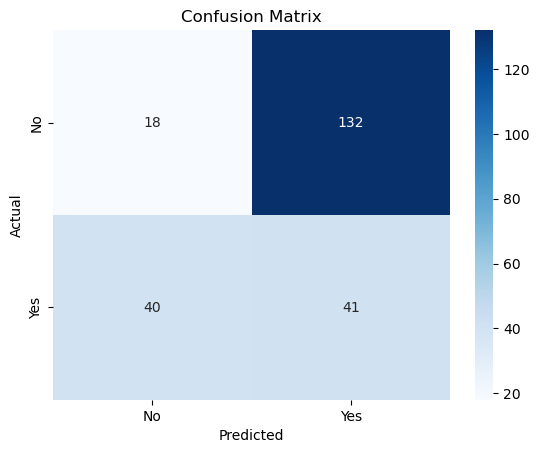

In [65]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Predict on test set
test['probs'] = model_probit.predict(test)
test['class'] = (test['probs'] > 0.5).astype(int)

# Metrics
y_true = test['Outcome'].astype(int)
y_pred = test['class']
y_prob = test['probs']

print("Model Performance on Test Set:")
print(f"Accuracy:  {accuracy_score(y_true, y_pred):.3f}")
print(f"Precision: {precision_score(y_true, y_pred):.3f}")
print(f"Sensitivity (Recall): {recall_score(y_true, y_pred):.3f}")
print(f"Specificity: {recall_score(y_true, y_pred, pos_label=0):.3f}")
print(f"F1-Score:  {f1_score(y_true, y_pred):.3f}")
print(f"AUC:       {roc_auc_score(y_true, y_prob):.3f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Mariginal Effect

In [67]:
margins = model_probit.get_margeff(at='overall', method='dydx')
print("\nAverage Marginal Effects:")
print(margins.summary())


Average Marginal Effects:
              GLM Marginal Effects             
Dep. Variable:     ['Outcome[0]', 'Outcome[1]']
Method:                                    dydx
At:                                     overall
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Preg          -0.2960      0.093     -3.178      0.001      -0.479      -0.113
Gluc          -0.8911      0.078    -11.386      0.000      -1.045      -0.738
BP             0.0885      0.151      0.587      0.557      -0.207       0.384
Skin          -0.1896      0.214     -0.884      0.377      -0.610       0.231
Insulin        0.0737      0.167      0.441      0.659      -0.254       0.401
BMI           -0.5690      0.145     -3.925      0.000      -0.853      -0.285
DPF           -0.1072      0.051     -2.106      0.035      -0.207      -0.007
Age           -0.1599      0.103     -1.555      0.120      -0.362    

### Predicted Probability

In [69]:
def predict_response_probit(model, data, term, values=None):
    """
    Compute predicted probabilities for a given term in a Probit model.
    Ensures the DataFrame passed to predict() has all required columns.
    """
    # Use mean values for all other covariates
    fixed_data = data[['Preg', 'Gluc', 'BP', 'Skin', 'Insulin', 'BMI', 'DPF', 'Age']].mean().to_dict()
    
    if values is None:
        values = sorted(data[term].unique())
    
    preds = []
    for val in values:
        # Modify the term of interest
        temp = fixed_data.copy()
        temp[term] = val
        
        # Create DataFrame with all required predictors (same as formula)
        X_df = pd.DataFrame([temp])[['Preg', 'Gluc', 'BP', 'Skin', 'Insulin', 'BMI', 'DPF', 'Age']]
        
        # Predict (statsmodels formula will handle intercept internally)
        prob = model.predict(X_df)[0]  # This returns probability directly
        preds.append(prob)
    
    return pd.DataFrame({'x': values, 'predicted': preds})

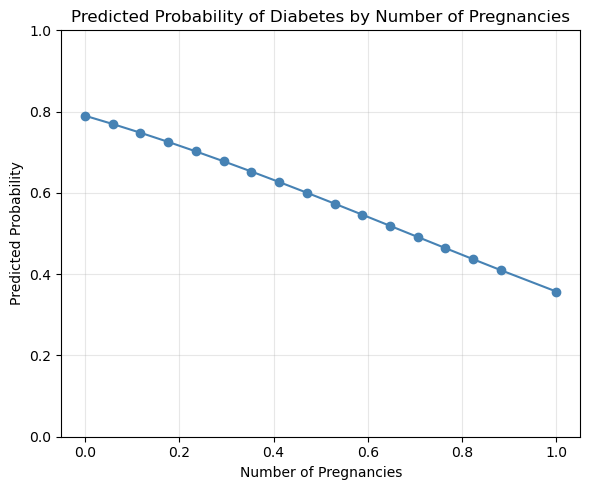

In [71]:
preg_effect = predict_response_probit(model_probit, train, "Preg")

plt.figure(figsize=(6, 5))
plt.plot(preg_effect['x'].values, preg_effect['predicted'].values,
         marker='o', color='steelblue', linestyle='-')
plt.title("Predicted Probability of Diabetes by Number of Pregnancies")
plt.xlabel("Number of Pregnancies")
plt.ylabel("Predicted Probability")
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Cross-Validation Probit Plots

In [73]:
k = 10
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=101)
cv_probits = np.zeros(len(df_clean))

X = df_clean.drop('Outcome', axis=1)
y = df_clean['Outcome']

for train_idx, val_idx in cv.split(X, y):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    train_fold = pd.concat([X_train, y_train], axis=1)
    cv_model = glm(formula, data=train_fold, family=Binomial(link=probit())).fit(disp=0)
    
    pred = cv_model.predict(X_val)
    cv_probits[val_idx] = pred

df_cv = df_clean[numeric_cols + ['Outcome']].copy()
df_cv['probs'] = cv_probits
df_cv['probit'] = norm.ppf(df_cv['probs'])

### Probit Linearity Check (Training, Test, CV)

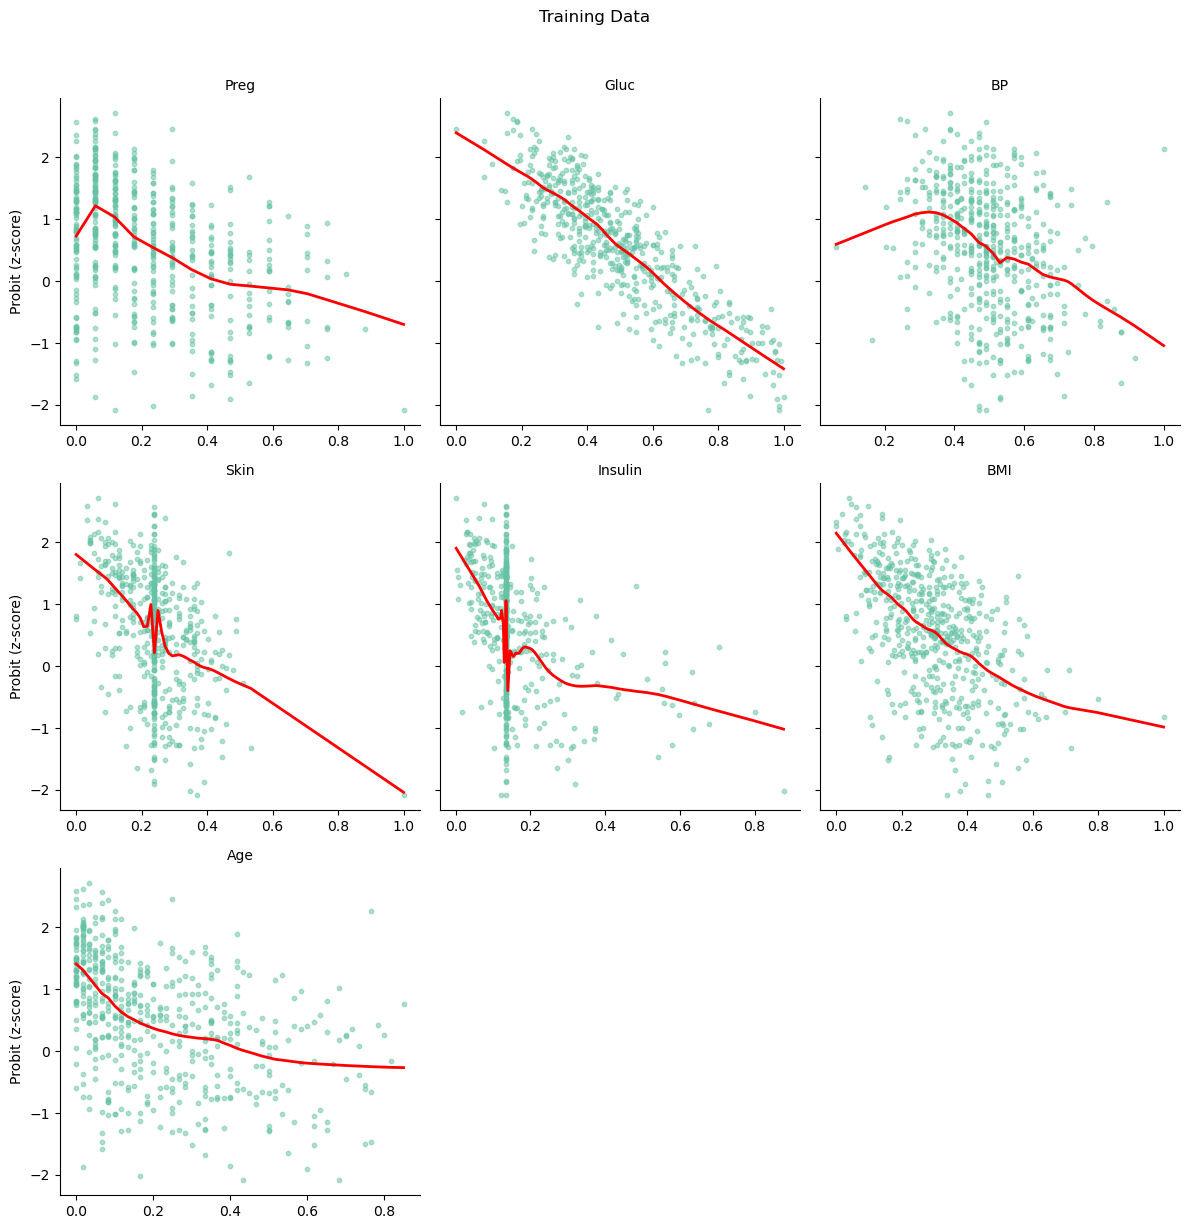

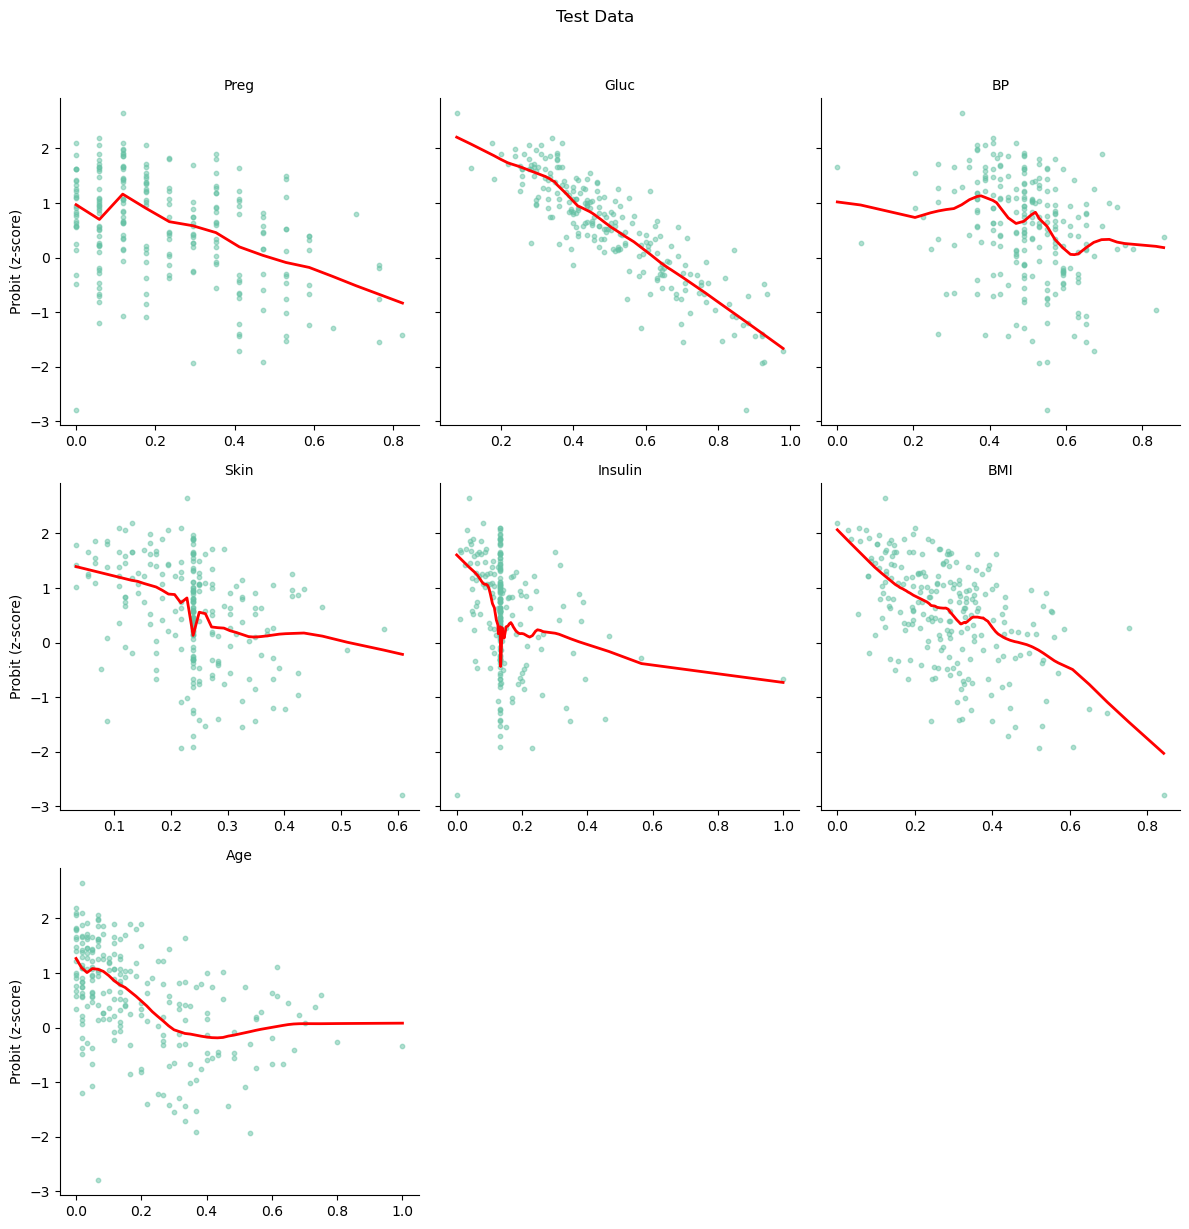

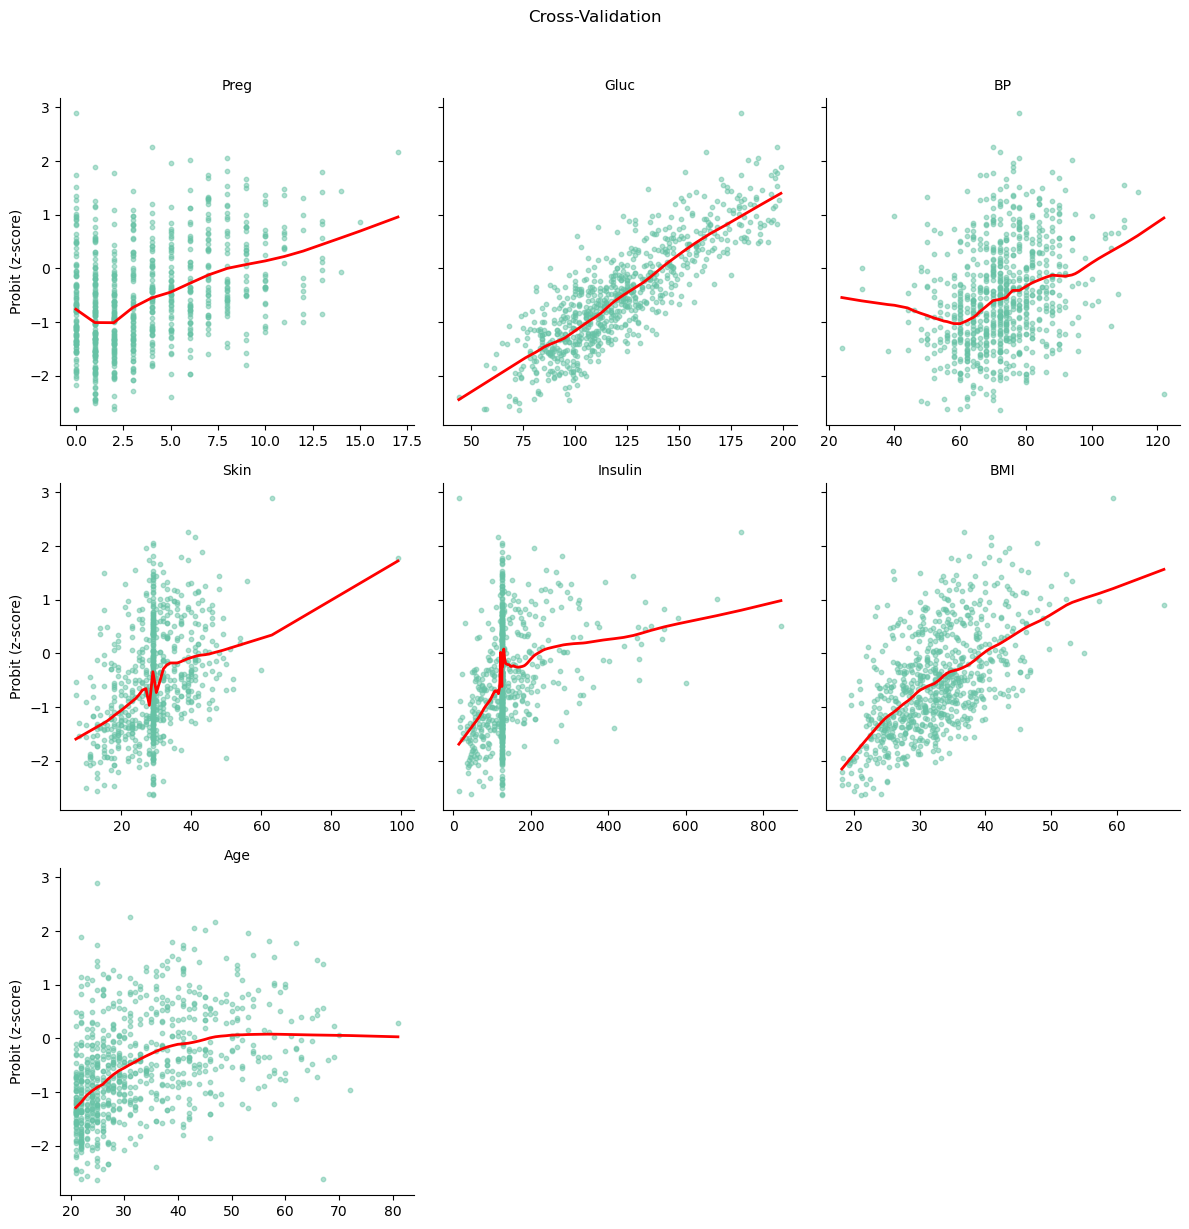

In [75]:
def plot_probit_relationship(data, model, covariates, title):
    data_subset = data[covariates].copy()
    if 'probs' not in data.columns:
        data_subset['probs'] = model.predict(data)
    else:
        data_subset['probs'] = data['probs']
    data_subset['probit'] = norm.ppf(data_subset['probs'])
    
    data_long = data_subset.melt(
        id_vars=['probit'], value_vars=covariates,
        var_name='predictors', value_name='predictor.value'
    )
    
    g = sns.FacetGrid(data_long, col='predictors', sharex=False, col_wrap=3, height=4)
    g.map(plt.scatter, 'predictor.value', 'probit', alpha=0.5, s=10)
    
    def smooth_line(x, y, **kwargs):
        from statsmodels.nonparametric.smoothers_lowess import lowess
        yx = lowess(y, x, frac=0.3)
        plt.plot(yx[:, 0], yx[:, 1], **kwargs)
    
    g.map(smooth_line, 'predictor.value', 'probit', color='red', linewidth=2)
    g.set_titles("{col_name}")
    g.set_axis_labels("", "Probit (z-score)")
    plt.suptitle(title, y=1.02)
    plt.tight_layout()
    plt.show()

# Training
plot_probit_relationship(train, model_probit, numeric_cols, "Training Data")

# Test
test['probs'] = model_probit.predict(test)
plot_probit_relationship(test, None, numeric_cols, "Test Data")

# CV
plot_probit_relationship(df_cv, None, numeric_cols, "Cross-Validation")

### Prediction and Evaluation


Test Set Performance:
Accuracy:  0.255
Precision: 0.237
Sensitivity: 0.506
Specificity: 0.120
F1-Score:  0.323
AUC:       0.186


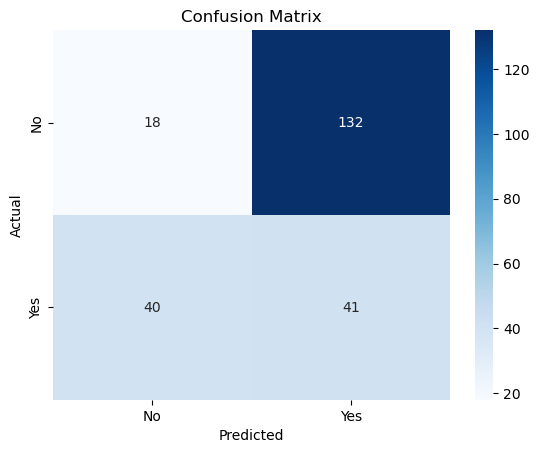

In [78]:
test['probs'] = model_probit.predict(test)
test['class'] = (test['probs'] > 0.5).astype(int)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

y_true = test['Outcome']
y_pred = test['class']
y_prob = test['probs']

print("\nTest Set Performance:")
print(f"Accuracy:  {accuracy_score(y_true, y_pred):.3f}")
print(f"Precision: {precision_score(y_true, y_pred):.3f}")
print(f"Sensitivity: {recall_score(y_true, y_pred):.3f}")
print(f"Specificity: {recall_score(y_true, y_pred, pos_label=0):.3f}")
print(f"F1-Score:  {f1_score(y_true, y_pred):.3f}")
print(f"AUC:       {roc_auc_score(y_true, y_prob):.3f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Summary and Conclusion

This R tutorial provides an overview of the Probit model, a statistical tool for modeling binary outcome variables. It guides users from understanding the theoretical foundations of the Probit model to implementing it in R. The Probit model is used when the dependent variable is binary and assumes that the relationship between independent variables and the probability of the event follows a cumulative normal distribution. The tutorial explains how to fit a model from scratch by calculating the likelihood function and using optimization techniques to obtain parameter estimates. It also demonstrates fitting a Probit model using R’s built-in `glm` function with the `binomial(link = "probit")` argument. This method streamlines the modeling process and provides functionalities for diagnostic checks. Participants learn to interpret coefficients, which reflect changes in the Z-score for unit changes in the predictors. To assess model performance, the tutorial employs cross-validation and evaluation on a hold-out test dataset. Cross-validation tests the model's stability across different data subsets, while the hold-out dataset evaluates accuracy, sensitivity, and specificity. By the end of the tutorial, participants gain a solid understanding of the Probit model, learning to fit models, interpret results, and evaluate performance. This equips them to effectively apply Probit regression in their research, making informed decisions based on the model's findings.

## References

1.  [Categorical Regression in Stata and R](https://bookdown.org/sarahwerth2024/CategoricalBook/probit-regression-r.html#running-a-probit-regression-in-r)

2.  [PROBIT REGRESSION \| R DATA ANALYSIS EXAMPLES](https://stats.oarc.ucla.edu/r/dae/probit-regression/)

3.  [Probit Regression in R, Python, Stata, and SAS](https://jbhender.github.io/Stats506/F18/GP/Group14.html)